In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

import matplotlib as mpl


# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [2]:
# Definizione funzioni
def retta(x,a,b):
    # Forse non necessaria, ma comunque meglio se la definisco
    return a*x+b

def parabola(x,a,b,c):
    return a*x**2+b*x+c

def A_R(f,Q,ft,A):
    return A/np.sqrt(1+Q**2*((ft/f)**2-(f/ft)**2)**2)

def A_C(f,Q,ft,A):
    return A/np.sqrt((1-(f/ft)**2)**2+(f/(Q*ft))**2)

def phi_R(f,Q,ft):
    return np.arctan(Q*(-ft/f+f/ft))

def phi_C(f,Q,ft,a):
    # a dovrebbe essere compatibile con np.pi/2
    return np.arctan(Q*(-ft/f+f/ft)) + a

In [15]:
# Importazione dei dati per fit globale
dataR = pd.read_csv('Dati R.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fR = dataR["f"]
phiR = 2e-6 * np.pi * dataR["f"] * dataR["dT"] # in rapporto a 90°
sphiR = 2e-6 * np.pi * dataR["f"] * np.sqrt(dataR["sT"]/(10*12**0.5))

VinR = dataR["Ach1"]
VoutR = dataR["Ach2"]

sVinR = np.sqrt((0.03*dataR["Ach1"]/(24**0.5))**2+(dataR["Sch1"]/(25*24**0.5))) # Assumo triangolare
sVoutR = np.sqrt((0.03*dataR["Ach2"]/(24**0.5))**2+(dataR["Sch2"]/(25*24**0.5))) # Assumo triangolare

TfR = dataR["Ach2"]/dataR["Ach1"]
sTfR = np.sqrt((0.03*dataR["Ach2"]/(12**0.5))**2+(dataR["Sch2"]/(25*12**0.5))**2 + (dataR["Ach2"]/dataR["Ach1"] * sVinR)**2)/dataR["Ach1"] # Assumo uniforme

In [4]:
# Importazione dei dati per fit globale
dataC = pd.read_csv('Dati C.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fC = dataC["f"]
phiC = 2e-9 * np.pi * dataC["f"] * dataC["dT"] # in rapporto a 90°
sphiC = 2e-6 * np.pi * dataC["f"] * np.sqrt(dataC["sT"]/(25*12**0.5))

VinC = dataC["Ach1"]
VoutC = dataC["Ach2"]

sVinC = np.sqrt((0.03*dataC["Ach1"]/(24**0.5))**2+(dataC["Sch1"]/(25*24**0.5))) # Assumo triangolare
sVoutC = np.sqrt((0.03*dataC["Ach2"]/(24**0.5))**2+(dataC["Sch2"]/(25*24**0.5))) # Assumo triangolare

TfC = dataC["Ach2"]/dataC["Ach1"]
sTfC = np.sqrt((0.03*dataC["Ach2"]/(12**0.5))**2+(dataC["Sch2"]/(25*12**0.5))**2 + (dataC["Ach2"]/dataC["Ach1"] * sVinC)**2)/dataC["Ach1"] # Assumo uniforme

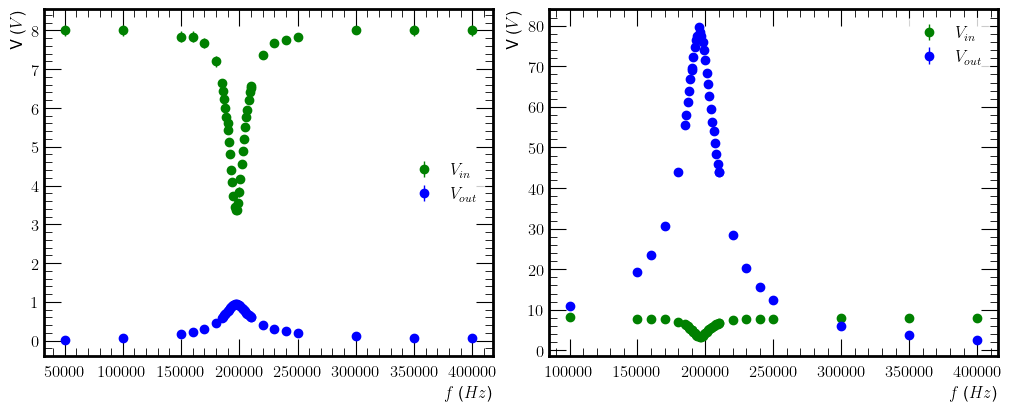

In [5]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(10,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, VinR, yerr=sVinR , label=r"$V_{in}$", fmt='go')
axA[0].errorbar(fR, VoutR, yerr=sVoutR, label=r"$V_{out}$" , fmt='bo')

axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"V ($V$)")

axA[0].legend(loc='center right')

axA[1].errorbar(fC, VinC, yerr=sVinC, label=r"$V_{in}$" , fmt='go')
axA[1].errorbar(fC, VoutC, yerr=sVoutC, label=r"$V_{out}$" , fmt='bo')

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"V ($V$)")

axA[1].legend(loc='upper right')

plt.show()

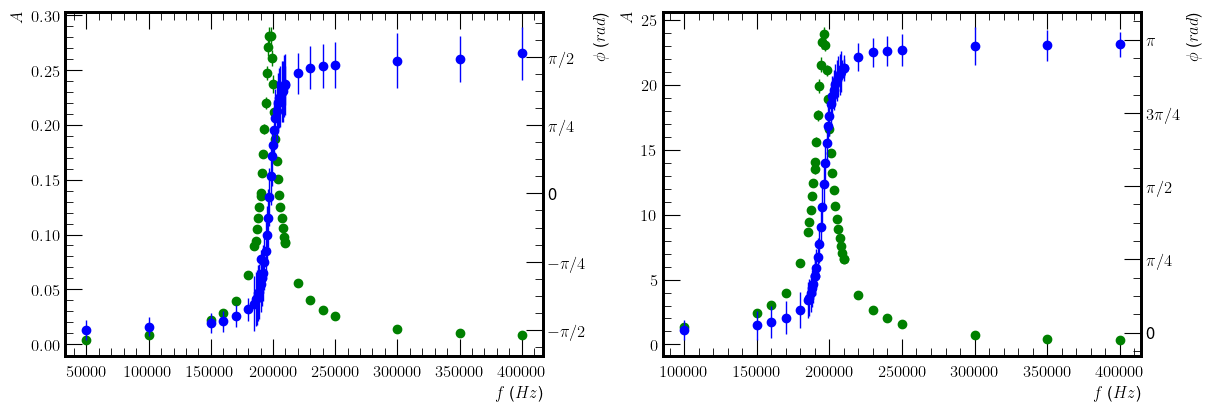

In [6]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(12,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, TfR, yerr=sTfR , fmt='go')
axF0 = axA[0].twinx()
axF0.errorbar(fR, phiR,  yerr= sphiR, fmt='bo')
axF0.set_yticks((-np.pi/2,-np.pi/4,0, np.pi/4, np.pi/2))
labels = axF0.set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$','0', r'$\pi / 4$', r'$\pi / 2$'))
axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$A$")
axF0.set_ylabel(r"$\phi$ ($rad$)")


axA[1].errorbar(fC, TfC, yerr=sTfC , fmt='go')
axF1 = axA[1].twinx()
axF1.errorbar(fC, phiC,  yerr= sphiC, fmt='bo')
axF1.set_yticks((0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axF1.set_yticklabels((r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$A$")
axF1.set_ylabel(r"$\phi$ ($rad$)")

plt.show()

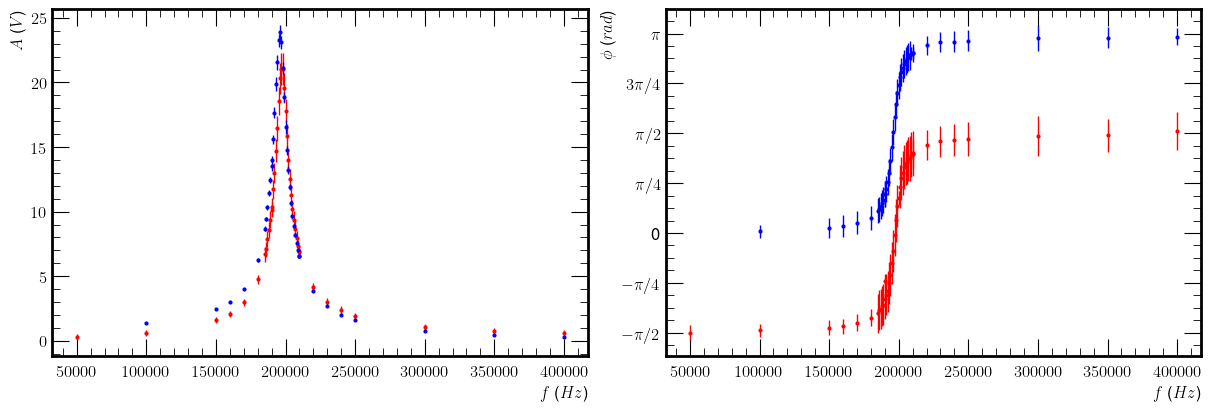

In [7]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(12,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, TfR*75, yerr=sTfR*75, fmt='ro', ms = 2)
axA[0].errorbar(fC, TfC, yerr=sTfC , fmt='bo', ms = 2)

axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$A$ ($V$)")


axA[1].errorbar(fR, phiR,  yerr= sphiR, fmt='ro', ms = 2)
axA[1].errorbar(fC, phiC,  yerr= sphiC, fmt='bo', ms = 2)

axA[1].set_yticks((-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axA[1].set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$',r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\phi$ ($rad$)")

plt.show()

0.08379946073976519
0.04543603637921593
0.11571384195069827
0.28029885233058827
0.7382787789329205
1.6348125774289353
2.5817990509100133
4.2182075668110635
6.622166675788038
9.07325803829665
11.782853860702373
15.26908445643715


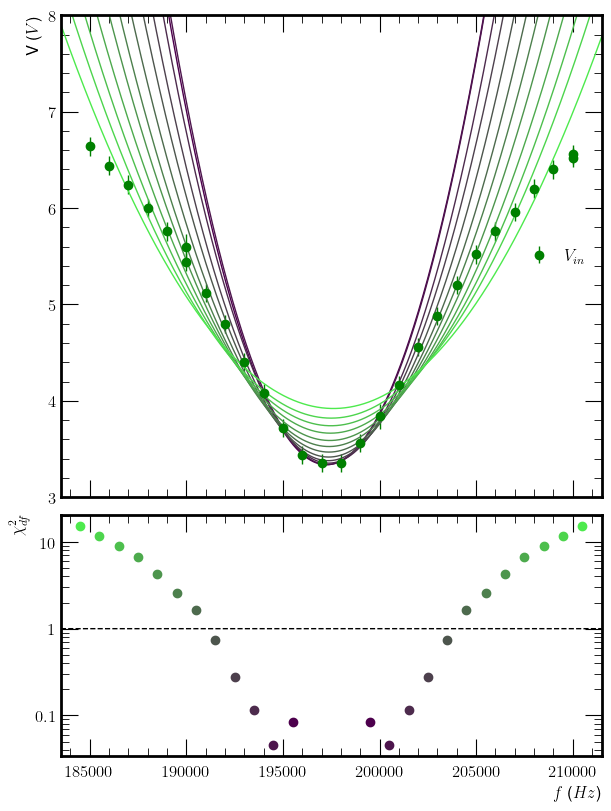

In [7]:
parpvaluelist = []
chi2parabole = []
h = 14
for i in range(2,h):
    parvalue, covparvalue = curve_fit(parabola, fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], method='lm' ,sigma=sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], absolute_sigma=True)
    parpvaluelist.append(parvalue)
    chi2parabole.append(np.sum(((VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3]-parabola(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],*parvalue))/sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])**2)/(len(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])-3))

    print(chi2parabole[i-2])

# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(6,8),sharex=True, constrained_layout = True, height_ratios = [2,1])

axA[0].errorbar(fR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], VinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], yerr=sVinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3] , label=r"$V_{in}$", fmt='go')

xfit = np.linspace(197500-h*1e3 , 197500+h*1e3 ,10000)

for i in range(len(parpvaluelist)):
    axA[0].plot(xfit, parabola(xfit, *parpvaluelist[i]), color=(0.3,i/len(parpvaluelist),0.3))

axA[0].set_ylabel(r"V ($V$)")

axA[0].set_xlim(197500-h*1e3,197500+h*1e3)
axA[0].set_ylim(3,8)


axA[0].legend(loc='center right')

for i in range(len(parpvaluelist)):
    axA[1].scatter(197500-(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))
    axA[1].scatter(197500+(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))

axA[1].plot(xfit, np.full(len(xfit),1), linestyle='--', color='black')


axA[1].semilogy()

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\chi ^ 2 _{df}$")

plt.show()


0.08379946073976519
0.04543603637921593
0.11571384195069827
0.28029885233058827
0.7382787789329205


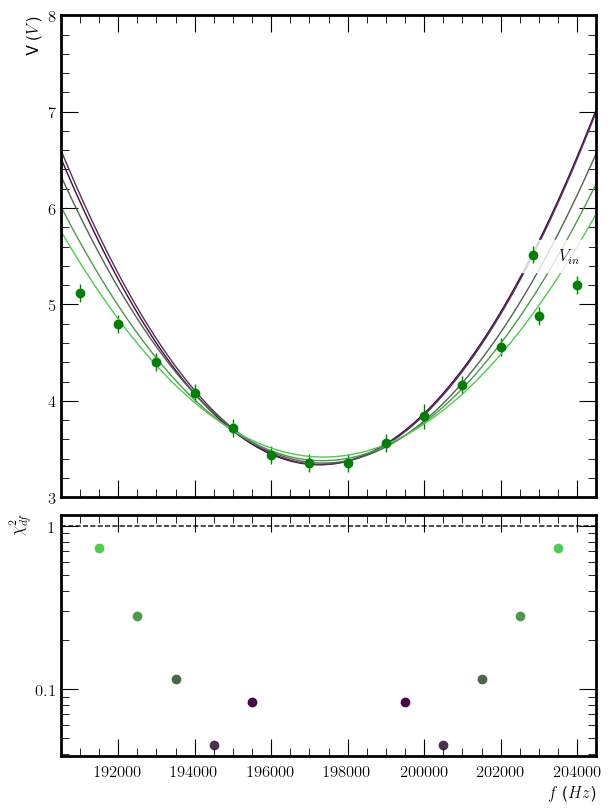

In [8]:
parpvaluelist = []
chi2parabole = []
h = 7
for i in range(2,h):
    parvalue, covparvalue = curve_fit(parabola, fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], method='lm' ,sigma=sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], absolute_sigma=True)
    parpvaluelist.append(parvalue)
    chi2parabole.append(np.sum(((VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3]-parabola(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],*parvalue))/sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])**2)/(len(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])-3))

    print(chi2parabole[i-2])

# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(6,8),sharex=True, constrained_layout = True, height_ratios = [2,1])

axA[0].errorbar(fR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], VinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], yerr=sVinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3] , label=r"$V_{in}$", fmt='go')

xfit = np.linspace(197500-h*1e3 , 197500+h*1e3 ,10000)

for i in range(len(parpvaluelist)):
    axA[0].plot(xfit, parabola(xfit, *parpvaluelist[i]), color=(0.3,i/len(parpvaluelist),0.3))

axA[0].set_ylabel(r"V ($V$)")

axA[0].set_xlim(197500-h*1e3,197500+h*1e3)
axA[0].set_ylim(3,8)


axA[0].legend(loc='center right')

for i in range(len(parpvaluelist)):
    axA[1].scatter(197500-(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))
    axA[1].scatter(197500+(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))

axA[1].plot(xfit, np.full(len(xfit),1), linestyle='--', color='black')


axA[1].semilogy()

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\chi ^ 2 _{df}$")

plt.show()


In [9]:
VinVuoto = 8 #V
sVinVuoto = np.sqrt((0.03*8/(24**0.5))**2+(2/(25*24**0.5))) # Assumo triangolare

Rg = 48.4
sRg = 0.7

parvalue, covpar = curve_fit(parabola, fR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3],VinR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3], method='lm' ,sigma=sVinR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3], absolute_sigma=True)

a, b, c = parvalue
sa, sb, sc = np.sqrt(np.diag(covpar))
sab, sbc = np.diag(covpar, 1)
sac = np.diag(covpar,2)[0]

fmin = -b/(2*a)
sfmin = fmin * np.sqrt((sb/b)**2+(sa/a)**2)

Vmin = parabola(fmin, *parvalue)
sVmin = np.sqrt(((2*a*fmin+b)*sfmin)**2+(fmin**2*sa)**2+(fmin*sb)**2+sc**2+2*fmin**3*sab+2*fmin*sbc+2*fmin**2*sac)

Rt = Rg/(1-Vmin/VinVuoto)
sRt = np.sqrt((sRg/(1-Vmin/VinVuoto))+(Rg*sVmin/((1-Vmin/VinVuoto)**2 * VinVuoto))**2 + (Rg*Vmin*sVmin/((1-Vmin/VinVuoto)**2 * VinVuoto))**2)

print("Rt = ", round(Rt), " +/- ", round(sRt), "Ohm")

Rt =  84  +/-  3 Ohm


In [22]:
f = []
sf = []
q = []
sq = []
cqf = []

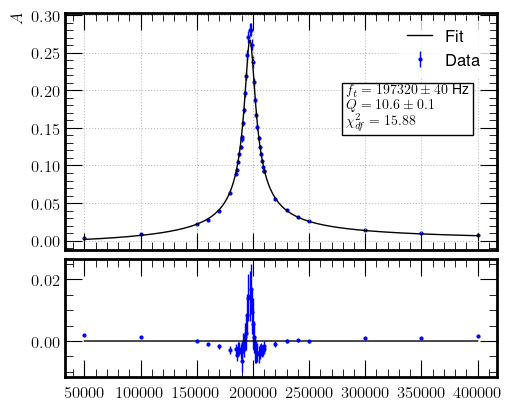

In [23]:
vAR, cvAR = curve_fit(A_R, fR, TfR, p0=[36, 196850, 0.3], method='lm' ,sigma=sTfR, absolute_sigma=True)

rAR = TfR - A_R(fR, *vAR)
df = len(fR)-3
chi2AR = np.sum((rAR/sTfR)**2)/df

q.append(vAR[0])
sq.append(np.sqrt(cvAR[0,0]))
f.append(vAR[1])
sf.append(np.sqrt(cvAR[1,1]))
cqf.append(cvAR[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fR)-100, max(fR) + 100, 4000)

ax[0].errorbar(fR,TfR, yerr=sTfR, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, A_R(xfit, *vAR), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vAR[1],-1), round(np.sqrt(cvAR[1,1]),-1)),
    r'$Q = %.1f \pm %.1f$ ' % (vAR[0], np.sqrt(cvAR[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2AR)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fR,rAR, yerr=sTfR, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

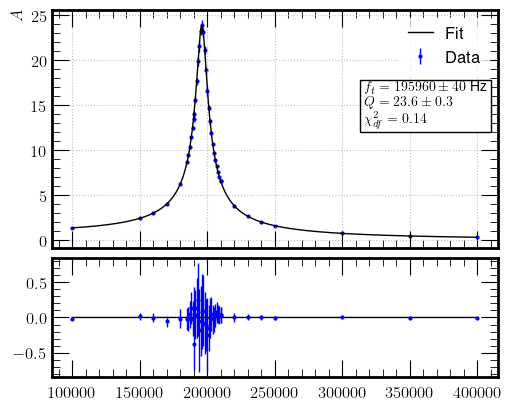

In [24]:
vAC, cvAC = curve_fit(A_C, fC, TfC, p0=[1, 196850, 1], method='lm' ,sigma=sTfC, absolute_sigma=True)

rAC = TfC - A_C(fC, *vAC)
df = len(fC)-3
chi2AC = np.sum((rAC/sTfC)**2)/df

q.append(vAC[0])
sq.append(np.sqrt(cvAC[0,0]))
f.append(vAC[1])
sf.append(np.sqrt(cvAC[1,1]))
cqf.append(cvAC[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fC)-100, max(fC) + 100, 4000)

ax[0].errorbar(fC,TfC, yerr=sTfC, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, A_C(xfit, *vAC), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vAC[1],-1), round(np.sqrt(cvAC[1,1]),-1)),
    r'$Q = %.1f \pm %.1f$ ' % (vAC[0], np.sqrt(cvAC[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2AC)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.7, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fC,rAC, yerr=sTfC, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

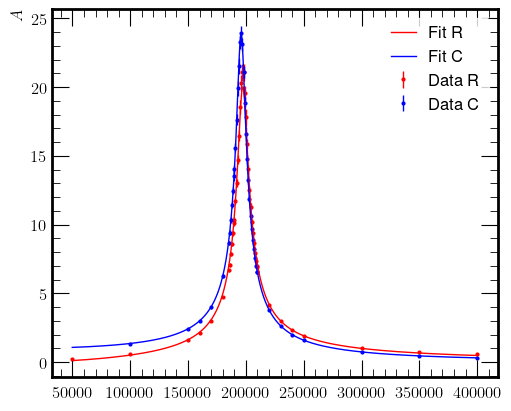

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,4),constrained_layout = True)

xfit = np.linspace(min(fR)-100, max(fC) + 100, 4000)

ax.plot(xfit, A_R(xfit, *vAR)*75, label='Fit R', linestyle = '-' ,color = 'r')
ax.errorbar(fR,TfR*75, yerr=sTfR*75, label='Data R', fmt='ro', ms=2, zorder = -1)

ax.plot(xfit, A_C(xfit, *vAC), label='Fit C', linestyle = '-' ,color = 'b')
ax.errorbar(fC,TfC, yerr=sTfC, label='Data C', fmt='bo', ms=2, zorder = -1)

ax.legend(loc='upper right')
ax.set_ylabel(r'$A$')

plt.show()

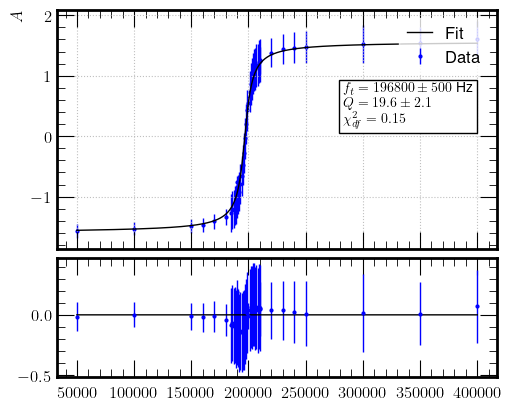

In [26]:
vphiR, cvphiR = curve_fit(phi_R, fR, phiR, p0=[12, 196850], method='lm' ,sigma=sphiR, absolute_sigma=True)

rphiR = phiR - phi_R(fR, *vphiR)
df = len(fR)-2
chi2phiR = np.sum((rphiR/sphiR)**2)/df

q.append(vphiR[0])
sq.append(np.sqrt(cvphiR[0,0]))
f.append(vphiR[1])
sf.append(np.sqrt(cvphiR[1,1]))
cqf.append(cvphiR[1,0])


fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fR)-100, max(fR) + 100, 4000)

ax[0].errorbar(fR,phiR, yerr=sphiR, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, phi_R(xfit, *vphiR), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vphiR[1],-2), round(np.sqrt(cvphiR[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ ' % (vphiR[0], np.sqrt(cvphiR[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2phiR)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fR,rphiR, yerr=sphiR, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

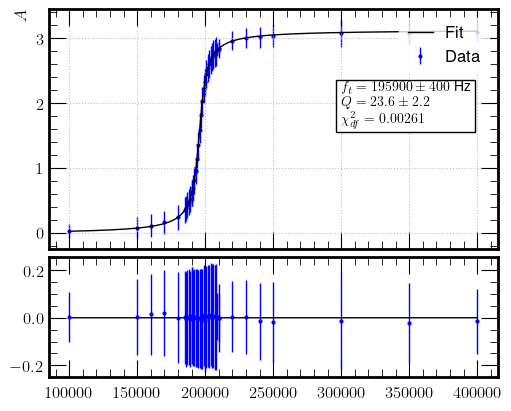

In [27]:
vphiC, cvphiC = curve_fit(phi_C, fC, phiC, p0=[12, 196850, np.pi/2], method='lm' ,sigma=sphiC, absolute_sigma=True)

rphiC = phiC - phi_C(fC, *vphiC)
df = len(fC)-2
chi2phiC = np.sum((rphiC/sphiC)**2)/df

q.append(vphiC[0])
sq.append(np.sqrt(cvphiC[0,0]))
f.append(vphiC[1])
sf.append(np.sqrt(cvphiC[1,1]))
cqf.append(cvphiC[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fC)-100, max(fC) + 100, 4000)

ax[0].errorbar(fC,phiC, yerr=sphiC, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, phi_C(xfit, *vphiC), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vphiC[1],-2), round(np.sqrt(cvphiC[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ ' % (vphiC[0], np.sqrt(cvphiC[0,0])),
    r'$\chi^2_{df} = %.5f $' % (chi2phiC)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fC,rphiC, yerr=sphiC, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

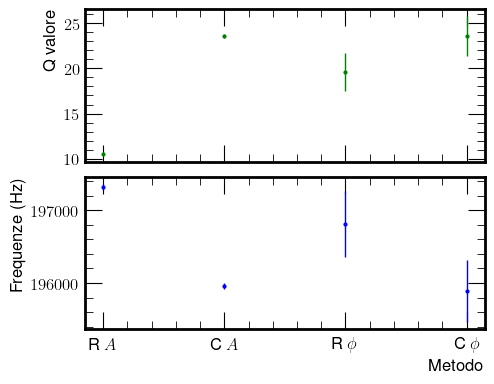

In [28]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], q,  yerr= sq , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], f,  yerr= sf , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"C $A$", r"R $\phi$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("Q valore")
ax[1].set_ylabel("Frequenze (Hz)")

plt.show()

In [29]:
# Stime di R e L con C fisso
Cfisso = 1.09*10**-9
sCfisso = 0.08*10**-9

f = np.array(f)
sf = np.array(sf)
q = np.array(q)
sq = np.array(sq)
cov = np.array(cqf)

L = 1/(f**2*Cfisso*4*np.pi**2)
sL = L * np.sqrt((sf/f)**2+(sCfisso/Cfisso)**2)

R = 1/(f*q*Cfisso*2*np.pi)
sR = R * np.sqrt((sf/f)**2 + (sCfisso/Cfisso)**2 + (sq/q)**2 + 2 * cov/(q*f))

for i in range(4):
    print("L: ", L[i], "+/-", sL[i])
for i in range(4):
    print("R: ", R[i], "+/-", sR[i])

L:  0.0005968725114158807 +/- 4.3807358314355647e-05
L:  0.0006051549551409179 +/- 4.441522486892741e-05
L:  0.0005999691722049443 +/- 4.405625842292891e-05
L:  0.0006056404733097701 +/- 4.4470286313604125e-05
R:  70.05238233173249 +/- 5.223814204572441
R:  31.57026404382765 +/- 2.3437463477382416
R:  37.897632866913334 +/- 4.908654833110255
R:  31.61107408743211 +/- 3.743284717981475


In [32]:
print("f [Hz]:")
for i in range(4):
    print(f[i], sf[i])

print("Q valore:")
for i in range(4):
    print(q[i], sq[i])

print("L [H]:")
for i in range(4):
    print(L[i], sL[i])

print("R [Ohm]:")
for i in range(4):
    print(R[i], sR[i])

f [Hz]:
197316.3142715961 125.23504739559002
195961.15013808126 42.7116122132782
196807.84897471813 454.8239623150695
195884.2136763244 427.0890976899424
Q valore:
11.563968892298995 0.4269517675003303
23.580133536364677 0.283593695026904
19.576684184318918 2.0851463265452357
23.58060500163929 2.196319049321088
L [H]:
0.0005968810297507194 4.3809419992716115e-05
0.0006051650046970724 4.441597601475153e-05
0.0005999691722049443 4.405625842292891e-05
0.0006056404733097701 4.4470286313604125e-05
R [Ohm]:
63.991711295136696 5.257623092819761
31.59929502784198 2.3501842875214956
37.897632866913334 4.908654833110255
31.61107408743211 3.743284717981475


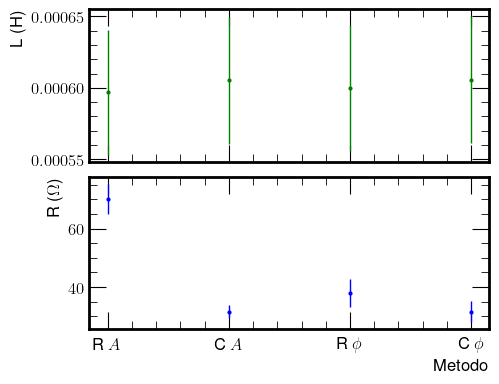

In [30]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], L,  yerr= sL , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], R,  yerr= sR , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"C $A$", r"R $\phi$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("L (H)")
ax[1].set_ylabel(r"R ($\Omega$)")

plt.show()

In [29]:
intersect = [[],[],[]]
for i in range(len(fC)):
    for j in range(len(fR)):
        if fC[i] == fR[j]:
            intersect[0].append(fC[i])
            intersect[1].append(phiC[i]-phiR[j])
            intersect[2].append((sphiC[i]**2+sphiR[j]**2)**0.5)

diff_phi = np.array(intersect[1])
sdiff_phi = np.array(intersect[2])
intersect = np.array(intersect[0])

[1.55822996 1.56451314 1.57833615 1.57016801 1.57205296 1.36332555
 1.64745119 1.77185826 1.59127951 1.5833627  1.57582288 1.56074323
 1.55018748 1.55508836 1.54566359 1.5393804  1.48283173 1.82557949
 1.87188657 1.85668126 1.82878392 1.78800604 1.71757154 1.67534853
 1.6581326  1.62784765 1.61006623 1.63086358 1.59976181 1.62055915
 1.58895473 1.59127951 1.5833627  1.79183879 1.74015959 1.72511136
 1.66212243 1.36332555 1.64745119 1.65065561 1.61829721 1.6214388
 1.58939456 1.6157211 ]


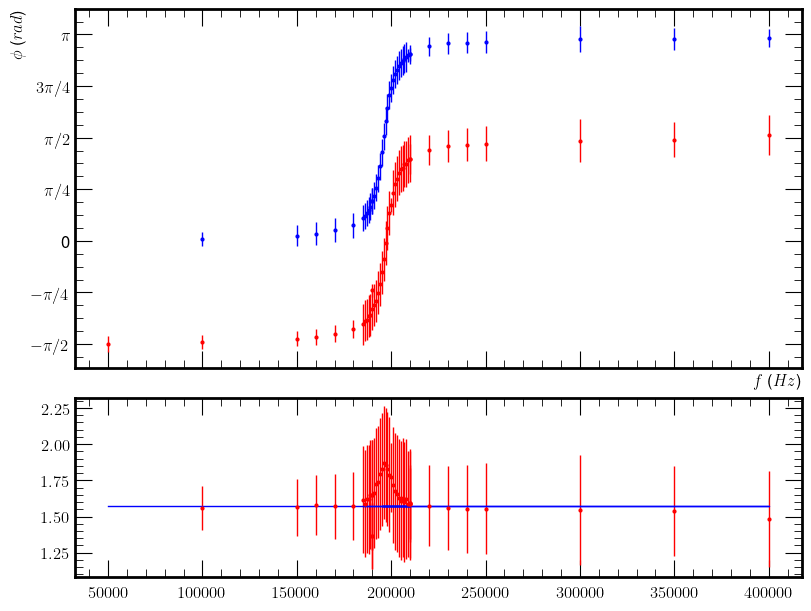

In [31]:
# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(8,6), sharex=True, constrained_layout = True, height_ratios=[2, 1])

axA[0].errorbar(fR, phiR,  yerr= sphiR, fmt='ro', ms = 2)
axA[0].errorbar(fC, phiC,  yerr= sphiC, fmt='bo', ms = 2)

axA[0].set_yticks((-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axA[0].set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$',r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$\phi$ ($rad$)")

axA[1].errorbar(intersect, diff_phi, yerr = sdiff_phi, fmt='ro', ms = 2)
axA[1].plot(fR, np.full(len(fR), np.pi/2))

plt.show()

In [39]:
# Funzioni per le mappe del chi2
def Chi2_A_R(x, y, sy, Q, ft, A):
    chi2 = np.sum(((y-A_R(x,Q,ft,A))/sy)**2)
    return chi2

def Chi2_A_C(x, y, sy, Q, ft, A):
    chi2 = np.sum(((y-A_C(x,Q,ft,A))/sy)**2)
    return chi2

def Chi2_phi_R(x, y, sy, Q, ft):
    chi2 = np.sum(((y-phi_R(x,Q,ft))/sy)**2)
    return chi2

def Chi2_A_C(x, y, sy, Q, ft, a):
    chi2 = np.sum(((y-phi_C(x,Q,ft,a))/sy)**2)
    return chi2

def profi2D(axis,mappa):
    step = len(mappa)
    if axis == 1 :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
    if axis == 2 :
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
    if axis == 3 :
        mappa2D = np.array([[np.min(mappa[a,b,:]) for a in range(step)] for b in range(step)])
    return mappa2D

def profi1D(axis, mappa):
    step = len(mappa)
    if 1 in axis :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
        if 2 in axis:
            mappa1D = np.array([np.min(mappa2D[b,:]) for b in range(step)])
        if 3 in axis:
            mappa1D = np.array([np.min(mappa2D[:,c]) for c in range(step)])
    else :
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
        mappa1D = np.array([np.min(mappa2D[a,:]) for a in range(step)])
    return mappa1D

In [42]:
import time

Q_AR, ft_AR, A_AR = vAR
sQ_AR, sft_AR, sA_AR = np.sqrt(np.diag(cvAR))

passi = 100
mappa = np.zeros((passi,passi,passi))
item = [(i,j,k) for i in range(passi) for j in range(passi) for k in range(passi)]

nSigma = 1
Q0, Q1 = Q_AR - nSigma * sQ_AR, Q_AR + nSigma * sQ_AR
ft0, ft1 = ft_AR - nSigma * sft_AR, ft_AR + nSigma * sft_AR
A0, A1 = A_AR - nSigma * sA_AR, A_AR + nSigma * sA_AR

stepQ =  (Q1-Q0)/passi
stepft =  (ft1-ft0)/passi
stepA =  (A1-A0)/passi

print("Progress Bar:")
for i in range(passi):
    print("_", end="")
print("\n")

start = time.time()

for i in range(passi):
    for j in range(passi):
        for k in range(passi):
            mappa[i][j][k] = Chi2_A_R(fR, TfR, sTfR, Q0+i*stepQ, ft0 + j*stepft, A0 + k*stepA)
    print("-", end="")
print("\n")
end = time.time()

print("C'ho messo : ", (end-start)//60, " minuti ", (end-start)%60, " secondi")

chi2_min = np.min(mappa)

argchi2_min = np.unravel_index(np.argmin(mappa),mappa.shape)

print(chi2_min)

Progress Qar:
____________________________________________________________________________________________________

----------------------------------------------------------------------------------------------------

C'ho messo :  40.0  minuti  27.133687496185303  secondi
2.8255791825402183


In [66]:
# Liste dei pezzi
Anp = np.linspace(A0,A1,passi)
Qnp = np.linspace(Q0,Q1,passi)
ftnp = np.linspace(ft0,ft1,passi)

Q_chi, ft_chi, A_chi = Q0 + stepQ * argchi2_min[0], ft0 + stepft * argchi2_min[1], A0 + stepA * argchi2_min[2]

#Calcolo Profilazione 2D
Qchi2D = profi2D(1,mappa)
ftchi2D = profi2D(2,mappa) 
Achi2D = profi2D(3,mappa)

#Calcolo Profilazioni 1D
prof_Q = profi1D([1,3],mappa)
prof_ft = profi1D([1,2],mappa)   
prof_A = profi1D([2,3],mappa)    

lvl = chi2_min + 1
diff_Q = abs(prof_Q-lvl)
diff_ft = abs(prof_ft-lvl)
diff_A = abs(prof_A-lvl)

Q_dx = np.argmin(diff_Q[Qnp<Q_AR])
Q_sx = np.argmin(diff_Q[Qnp>Q_AR])+len(diff_Q[Qnp<Q_AR])
ft_dx = np.argmin(diff_ft[ftnp<ft_AR])
ft_sx = np.argmin(diff_ft[ftnp>ft_AR])+len(diff_ft[ftnp<ft_AR])
A_dx = np.argmin(diff_A[Anp<A_AR])
A_sx = np.argmin(diff_A[Qnp>A_AR])+len(diff_A[Anp<A_AR])

print(Q_dx, Q_sx, A_dx, A_sx, ft_dx, ft_sx)
print(Qnp[ft_sx]-Q_chi,Qnp[ft_dx]-Q_chi)
print(ftnp[Q_sx]-ft_chi,ftnp[Q_dx]-ft_chi)
print("---")
print(Anp[A_sx]-A_chi,Anp[A_dx]-A_chi)
print(ftnp[ft_sx]-ft_chi,ftnp[ft_dx]-ft_chi)



cmap = mpl.colormaps['plasma'].reversed()
print(Qchi2D.shape)
level = np.linspace(np.min(Qchi2D),np.max(Qchi2D),100)
line_c = 'gray'

fig, ax = plt.subplots(2, 3, figsize=(6, 5),layout="tight", height_ratios=[3, 1], width_ratios=[1,3,0.15], sharex='col', sharey='row')
im = ax[0,1].contourf(Qnp,ftnp,Qchi2D, levels=level, cmap=cmap) 
cbar = fig.colorbar(im, use_gridspec = True, fraction = 1, extend='both', shrink=1, ax=ax[0,2], ticks = range(int(np.min(Qchi2D)), int(np.max(Qchi2D)), 50)) 
cbar.set_label(r'$\chi^2$',rotation=360)

CS = ax[0,1].contour(Qnp,ftnp,Qchi2D, levels=[chi2_min+0.0001,chi2_min+1,chi2_min+2.3,chi2_min+3.8],linewidths=1, colors='k',alpha=0.5,linestyles='dotted')
ax[0,1].clabel(CS, inline=True, fontsize=9, fmt='%10.0f')
print(np.argmin(prof_Q),np.argmin(prof_ft),Qnp[np.argmin(prof_Q)],ftnp[np.argmin(prof_ft)])
#ax[0,1].text(Q[np.argmin(prof_Q)],ft[np.argmin(prof_ft)]+50.,str(np.around(chi2_min,1)), color='k',alpha=0.5, fontsize=9)
ax[0,1].plot([Q0,Q1],[ftnp[ft_sx],ftnp[ft_sx]],color=line_c, ls='dashed')
ax[0,1].plot([Q0,Q1],[ftnp[ft_dx],ftnp[ft_dx]],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[ft0,ft1],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[ft0,ft1],color=line_c, ls='dashed')

ax[0,0].plot(prof_ft,ftnp,ls='-') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_sx],ftnp[ft_sx]], color=line_c, ls='dashed') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_dx],ftnp[ft_dx]], color=line_c, ls='dashed')
ax[0,0].set_xticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])
#ax[0,0].text(49,ft[np.argmin(prof_ft)],str(np.around(ft[np.argmin(prof_ft)],0)), color='k',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_sx]+50.,str(np.around(ft[Q_sx]-ft[np.argmin(prof_ft)],0)), color='b',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_dx]-120.,str(np.around(ft[Q_dx]-ft[np.argmin(prof_ft)],0)), color='r',alpha=0.5, fontsize=9)

ax[1,1].plot(Qnp,prof_Q) 
ax[1,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
ax[1,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
#ax[1,1].text(Q[np.argmin(prof_Q)]-200,50,str(np.around(Q[np.argmin(prof_Q)],0)), color='k',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_sx]+50.,54.5,str(np.around(Q[ft_sx]-Q[np.argmin(prof_Q)],0)), color='b',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_dx]-270.,54.5,str(np.around(Q[ft_dx]-Q[np.argmin(prof_Q)],0)), color='r',alpha=0.5, fontsize=9)
ax[1,1].set_yticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])

plt.xticks(ticks=plt.xticks()[0][1:-1], labels= 1000 * np.round(np.array(plt.xticks()[0][1:-1], dtype=np.float64), 4))

ax[1,0].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()

ax[0,0].set_ylabel(r'ft ($Hz$)') 
ax[1,1].set_xlabel('Q') 
ax[0,0].set_xlim(int(chi2_min-2),int(chi2_min+10)) 
ax[1,1].set_ylim(int(chi2_min-2),int(chi2_min+10))

plt.savefig('Chi2_Qft'+'.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='Portrait',
            dpi = 250)


plt.show()

ValueError: attempt to get argmin of an empty sequence

In [ ]:
import time

Q_AC, ft_AC, A_AC = vAC
sQ_AC, sft_AC, sA_AC = np.sqrt(np.diag(cvAC))

passi = 100
mappa2 = np.zeros((passi,passi,passi))
item = [(i,j,k) for i in range(passi) for j in range(passi) for k in range(passi)]

nSigma = 2
Q02, Q12 = Q_AC - nSigma * sQ_AC, Q_AC + nSigma * sQ_AC
ft0, ft12 = ft_AC - nSigma * sft_AC, ft_AC + nSigma * sft_AC
A0, A12 = A_AC - nSigma * sA_AC, A_AC + nSigma * sA_AC

stepQ =  (Q1-Q02)/passi
stepft =  (ft1-ft0)/passi
stepA =  (A1-A0)/passi

print("Progress Bar:")
for i in range(passi):
    print("_", end="")
print("\n")

start = time.time()

for i in range(passi):
    for j in range(passi):
        for k in range(passi):
            mappa2[i][j][k] = Chi2_A_C(fC, TfC, sTfC, Q02+i*stepQ, ft0 + j*stepft, A0 + k*stepA)
    print("-", end="")
print("\n")
end = time.time()

print("C'ho messo : ", (end-start)//60, " minuti ", (end-start)%60, " secondi")

chi2_min2 = np.min(mappa2)

argchi2_min2 = np.unravel_index(np.argmin(mappa2),mappa2.shape)

print(chi2_min)

Progress Bar:
____________________________________________________________________________________________________

--------------------------------------------------------------------

In [55]:
print((Anp[0],Anp[-1]), (Qnp[0],Qnp[-1]), (ftnp[0],ftnp[-1]))

(np.float64(1.005399036875245), np.float64(1.0148112819657584)) (np.float64(23.296539841337772), np.float64(23.863727231391582)) (np.float64(195918.43852586797), np.float64(196003.86175029454))


(100, 100)
0 0 23.296539841337772 195918.43852586797
--


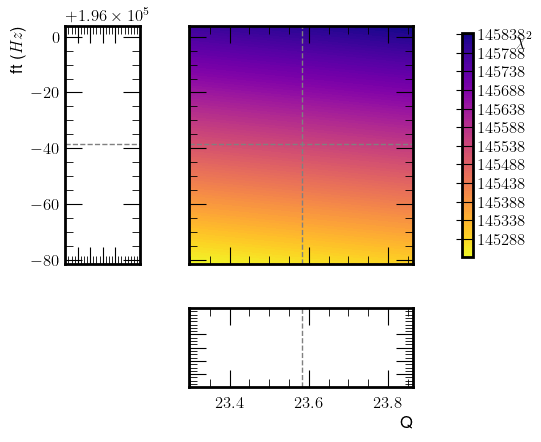

In [65]:
# Liste dei pezzi
Anp = np.linspace(A0,A1,passi)
Qnp = np.linspace(Q0,Q1,passi)
ftnp = np.linspace(ft0,ft1,passi)

Q_chi, ft_chi, A_chi = Q0 + stepQ * argchi2_min2[0], ft0 + stepft * argchi2_min2[1], A0 + stepA * argchi2_min2[2]

#Calcolo Profilazione 2D
Qchi2D = profi2D(1,mappa2)
ftchi2D = profi2D(2,mappa2) 
Achi2D = profi2D(3,mappa2)

#Calcolo Profilazioni 1D
prof_ft = profi1D([1,3],mappa2)
prof_A = profi1D([1,2],mappa2)   
prof_Q = profi1D([2,3],mappa2)    

lvl = chi2_min + 1
diff_Q = abs(prof_Q-lvl)
diff_ft = abs(prof_ft-lvl)
diff_A = abs(prof_A-lvl)

Q_dx = np.argmin(diff_Q[Qnp<Q_AC])
Q_sx = np.argmin(diff_Q[Qnp>Q_AC])+len(diff_Q[Qnp<Q_AC])
ft_dx = np.argmin(diff_ft[ftnp<ft_AC])
ft_sx = np.argmin(diff_ft[ftnp>ft_AC])+len(diff_ft[ftnp<ft_AC])
A_dx = np.argmin(diff_A[Anp<A_AC])
A_sx = np.argmin(diff_A[Anp>A_AC])+len(diff_A[Anp<A_AC])

cmap = mpl.colormaps['plasma'].reversed()
print(Qchi2D.shape)
level = np.linspace(np.min(Qchi2D),np.max(Qchi2D),100)
line_c = 'gray'

fig, ax = plt.subplots(2, 3, figsize=(6, 5),layout="tight", height_ratios=[3, 1], width_ratios=[1,3,0.15], sharex='col', sharey='row')
im = ax[0,1].contourf(Qnp,ftnp,Qchi2D, levels=level, cmap=cmap) 
cbar = fig.colorbar(im, use_gridspec = True, fraction = 1, extend='both', shrink=1, ax=ax[0,2], ticks = range(int(np.min(Qchi2D)), int(np.max(Qchi2D)), 50)) 
cbar.set_label(r'$\chi^2$',rotation=360)

CS = ax[0,1].contour(Qnp,ftnp,Qchi2D, levels=[chi2_min+0.0001,chi2_min+1,chi2_min+2.3,chi2_min+3.8],linewidths=1, colors='k',alpha=0.5,linestyles='dotted')
ax[0,1].clabel(CS, inline=True, fontsize=9, fmt='%10.0f')
print(np.argmin(prof_Q),np.argmin(prof_ft),Qnp[np.argmin(prof_Q)],ftnp[np.argmin(prof_ft)])
#ax[0,1].text(Q[np.argmin(prof_Q)],ft[np.argmin(prof_ft)]+50.,str(np.around(chi2_min,1)), color='k',alpha=0.5, fontsize=9)
ax[0,1].plot([Q0,Q1],[ftnp[ft_sx],ftnp[ft_sx]],color=line_c, ls='dashed')
ax[0,1].plot([Q0,Q1],[ftnp[ft_dx],ftnp[ft_dx]],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[ft0,ft1],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[ft0,ft1],color=line_c, ls='dashed')

ax[0,0].plot(prof_ft,ftnp,ls='-') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_sx],ftnp[ft_sx]], color=line_c, ls='dashed') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_dx],ftnp[ft_dx]], color=line_c, ls='dashed')
ax[0,0].set_xticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])
#ax[0,0].text(49,ft[np.argmin(prof_ft)],str(np.around(ft[np.argmin(prof_ft)],0)), color='k',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_sx]+50.,str(np.around(ft[Q_sx]-ft[np.argmin(prof_ft)],0)), color='b',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_dx]-120.,str(np.around(ft[Q_dx]-ft[np.argmin(prof_ft)],0)), color='r',alpha=0.5, fontsize=9)

ax[1,1].plot(Qnp,prof_Q) 
ax[1,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
ax[1,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
#ax[1,1].text(Q[np.argmin(prof_Q)]-200,50,str(np.around(Q[np.argmin(prof_Q)],0)), color='k',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_sx]+50.,54.5,str(np.around(Q[ft_sx]-Q[np.argmin(prof_Q)],0)), color='b',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_dx]-270.,54.5,str(np.around(Q[ft_dx]-Q[np.argmin(prof_Q)],0)), color='r',alpha=0.5, fontsize=9)
ax[1,1].set_yticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])

plt.xticks(ticks=plt.xticks()[0][1:-1], labels= np.round(np.array(plt.xticks()[0][1:-1], dtype=np.float64), 4))

ax[1,0].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()

ax[0,0].set_ylabel(r'ft ($Hz$)') 
ax[1,1].set_xlabel('Q') 
ax[0,0].set_xlim(int(chi2_min-2),int(chi2_min+10)) 
ax[1,1].set_ylim(int(chi2_min-2),int(chi2_min+10))

plt.savefig('Chi2_Qft'+'.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='Portrait',
            dpi = 250)

print("--")

plt.show()

In [ ]:
import time

Q_phiR, ft_phiR = vphiR
sQ_phiR, sft_phiR = np.sqrt(np.diag(cvphiR))

passi = 100
mappa3 = np.zeros((passi,passi))
item = [(i,j) for i in range(passi) for j in range(passi)]

nSigma = 1
Q0, Q1 = Q_phiR - nSigma * sQ_phiR, Q_phiR + nSigma * sQ_phiR
ft0, ft1 = ft_phiR - nSigma * sft_phiR, ft_phiR + nSigma * sft_phiR

stepQ =  (Q1-Q0)/passi
stepft =  (ft1-ft0)/passi
print("Progress Bar:")
for i in range(passi):
    print("_", end="")
print("\n")

start = time.time()

for i in range(passi):
    for j in range(passi):
        mappa3[i][j] = Chi2_A_C(fC, TfC, sTfC, Q0+i*stepQ, ft0 + j*stepft)
    print("-", end="")
print("\n")
end = time.time()

print("C'ho messo : ", (end-start)//60, " minuti ", (end-start)%60, " secondi")

chi2_min = np.min(mappa3)

argchi2_min = np.unravel_index(np.argmin(mappa3),mappa3.shape)

print(chi2_min)

In [ ]:
def prof2D1D(axis, mappa):
    step = len(mappa)
    if 1 == axis :
        mappa2D = np.array([np.min(mappa[:b]) for b in range(step)])
    else :
        mappa2D = np.array([np.min(mappa[b:]) for b in range(step)])
    return mappa2D

In [ ]:
# Liste dei pezzi
Qnp = np.linspace(Q0,Q1,passi)
ftnp = np.linspace(ft0,ft1,passi)

Q_chi, ft_chi = Q0 + stepQ * argchi2_min[0], ft0 + stepft * argchi2_min[1]

#Calcolo Profilazione 2D
Qchi2D = profi2D(1,mappa2)
ftchi2D = profi2D(2,mappa2) 

#Calcolo Profilazioni 1D
prof_Q = profi1D([1,3],mappa2)
prof_ft = profi1D([1,2],mappa2)   

lvl = chi2_min + 1
diff_Q = abs(prof_Q-lvl)
diff_ft = abs(prof_ft-lvl)
diff_Q = abs(prof_Q-lvl)

Q_dx = np.argmin(diff_Q[Qnp<Q_AR])
Q_sx = np.argmin(diff_Q[Qnp>Q_AR])+len(diff_Q[Qnp<Q_AR])
ft_dx = np.argmin(diff_ft[ftnp<ft_AR])
ft_sx = np.argmin(diff_ft[ftnp>ft_AR])+len(diff_ft[ftnp<ft_AR])
Q_dx = np.argmin(diff_Q[Qnp<Q_AR])
Q_sx = np.argmin(diff_Q[Qnp>Q_AR])+len(diff_Q[Qnp<Q_AR])

print(Q_dx, Q_sx, Q_dx, Q_sx, ft_dx, ft_sx)
print(Qnp[ft_sx]-Q_chi,Qnp[ft_dx]-Q_chi)
print(ftnp[Q_sx]-ft_chi,ftnp[Q_dx]-ft_chi)
print("---")
print(Qnp[Q_sx]-Q_chi,Qnp[Q_dx]-Q_chi)
print(ftnp[ft_sx]-ft_chi,ftnp[ft_dx]-ft_chi)



cmap = mpl.colormaps['plasma'].reversed()
print(Qchi2D.shape)
level = np.linspace(np.min(Qchi2D),np.max(Qchi2D),100)
line_c = 'gray'

fig, ax = plt.subplots(2, 3, figsize=(6, 5),layout="tight", height_ratios=[3, 1], width_ratios=[1,3,0.15], sharex='col', sharey='row')
im = ax[0,1].contourf(Qnp,ftnp,Qchi2D, levels=level, cmap=cmap) 
cbar = fig.colorbar(im, use_gridspec = True, fraction = 1, extend='both', shrink=1, ax=ax[0,2], ticks = range(1860, int(np.max(Qchi2D)), 10)) 
cbar.set_label(r'$\chi^2$',rotation=360)

CS = ax[0,1].contour(Qnp,ftnp,Qchi2D, levels=[chi2_min+0.0001,chi2_min+1,chi2_min+2.3,chi2_min+3.8],linewidths=1, colors='k',alpha=0.5,linestyles='dotted')
ax[0,1].clabel(CS, inline=True, fontsize=9, fmt='%10.0f')
print(np.argmin(prof_Q),np.argmin(prof_ft),Qnp[np.argmin(prof_Q)],ftnp[np.argmin(prof_ft)])
#ax[0,1].text(Q[np.argmin(prof_Q)],ft[np.argmin(prof_ft)]+50.,str(np.around(chi2_min,1)), color='k',alpha=0.5, fontsize=9)
ax[0,1].plot([Q0,Q1],[ftnp[ft_sx],ftnp[ft_sx]],color=line_c, ls='dashed')
ax[0,1].plot([Q0,Q1],[ftnp[ft_dx],ftnp[ft_dx]],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[ft0,ft1],color=line_c, ls='dashed')
ax[0,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[ft0,ft1],color=line_c, ls='dashed')

ax[0,0].plot(prof_ft,ftnp,ls='-') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_sx],ftnp[ft_sx]], color=line_c, ls='dashed') 
ax[0,0].plot([int(chi2_min-2),int(chi2_min+10)],[ftnp[ft_dx],ftnp[ft_dx]], color=line_c, ls='dashed')
ax[0,0].set_xticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])
#ax[0,0].text(49,ft[np.argmin(prof_ft)],str(np.around(ft[np.argmin(prof_ft)],0)), color='k',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_sx]+50.,str(np.around(ft[Q_sx]-ft[np.argmin(prof_ft)],0)), color='b',alpha=0.5, fontsize=9)
#ax[0,0].text(52,ft[Q_dx]-120.,str(np.around(ft[Q_dx]-ft[np.argmin(prof_ft)],0)), color='r',alpha=0.5, fontsize=9)

ax[1,1].plot(Qnp,prof_Q) 
ax[1,1].plot([Qnp[Q_sx],Qnp[Q_sx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
ax[1,1].plot([Qnp[Q_dx],Qnp[Q_dx]],[int(chi2_min-2),int(chi2_min+10)], color=line_c, ls='dashed') 
#ax[1,1].text(Q[np.argmin(prof_Q)]-200,50,str(np.around(Q[np.argmin(prof_Q)],0)), color='k',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_sx]+50.,54.5,str(np.around(Q[ft_sx]-Q[np.argmin(prof_Q)],0)), color='b',alpha=0.5, fontsize=9)
#ax[1,1].text(Q[ft_dx]-270.,54.5,str(np.around(Q[ft_dx]-Q[np.argmin(prof_Q)],0)), color='r',alpha=0.5, fontsize=9)
ax[1,1].set_yticks([int(chi2_min),int(chi2_min+2),int(chi2_min+4),int(chi2_min+6)])

plt.xticks(ticks=plt.xticks()[0][1:-1], labels= 1000 * np.round(np.array(plt.xticks()[0][1:-1], dtype=np.float64), 4))

ax[1,0].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()

ax[0,0].set_ylabel(r'ft ($Hz$)') 
ax[1,1].set_xlabel('Q )') 
ax[0,0].set_xlim(int(chi2_min-2),int(chi2_min+10)) 
ax[1,1].set_ylim(int(chi2_min-2),int(chi2_min+10))

plt.savefig('Chi2_Qft'+'.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='Portrait',
            dpi = 250)


plt.show()

In [ ]:
import time

Q_phiC, ft_phiC, A_phiC = vphiC
sQ_phiC, sft_phiC, sA_phiC = np.sqrt(np.diag(cvphiC))

passi = 100
mappa4 = np.zeros((passi,passi,passi))
item = [(i,j,k) for i in range(passi) for j in range(passi) for k in range(passi)]

nSigma = 1
Q0, Q1 = Q_phiC - nSigma * sQ_phiC, Q_phiC + nSigma * sQ_phiC
ft0, ft1 = ft_phiC - nSigma * sft_phiC, ft_phiC + nSigma * sft_phiC
A0, A1 = A_phiC - nSigma * sA_phiC, A_phiC + nSigma * sA_phiC

stepQ =  (Q1-Q0)/passi
stepft =  (ft1-ft0)/passi
stepA =  (A1-A0)/passi

print("Progress Qar:")
for i in range(passi):
    print("_", end="")
print("\n")

start = time.time()

for i in range(passi):
    for j in range(passi):
        for k in range(passi):
            mappa4[i][j][k] = Chi2_A_R(fR, TfR, sTfR, Q0+i*stepQ, ft0 + j*stepft, A0 + k*stepA)
    print("-", end="")
print("\n")
end = time.time()

print("C'ho messo : ", (end-start)//60, " minuti ", (end-start)%60, " secondi")

chi2_min = np.min(mappa4)

argchi2_min = np.unravel_index(np.argmin(mappa4),mappa4.shape)

print(chi2_min)